## Import Libraries 

In [2]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torch.autograd import Variable

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torchvision

import PIL.Image as Image
import io
import matplotlib.pyplot as plt

## Load data

We use MNIST data for training and evaluation

In [3]:
data1 = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

Label: 5
torch.Size([28, 28])


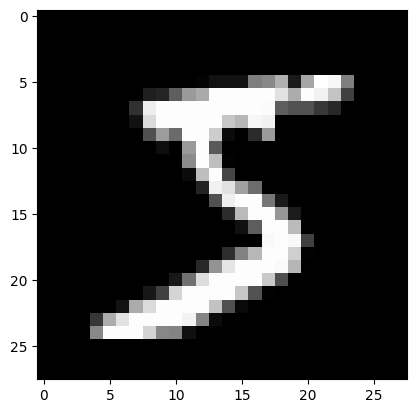

In [34]:
image,label = data1[0]
plt.imshow(image[0,:,:], cmap = 'gray')
print("Label:", label)

## Preprocess data

Enrich data by removing black pixel (padding) around the digit pictures

After remove padding, remember to resize the image to 28x28

In [5]:
def remove_padding(img):
    
    non_zero_rows = torch.any(img[0] != 0, dim=1)
    non_zero_cols = torch.any(img[0] != 0, dim=0)

    a1 = torch.arange(28)
    a2 = torch.arange(28)
    a1=a1[non_zero_rows]
    a2=a2[non_zero_cols]

    img = img[:,a1[0]:a1[-1]+1,a2[0]:a2[-1]+1]
    img = torchvision.transforms.Resize((28,28))(img)
    return img
    

In [35]:
data2 = []
for i in data1:
    img = i[0]
    img = remove_padding(img)
    data2.append((img,i[1]))
index = 0



torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 2

KeyboardInterrupt: 

Image after removing padding:


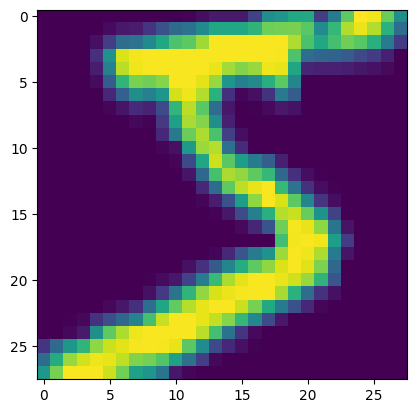

In [7]:
index = 0
print("Image after removing padding:")
plt.imshow(data2[0][0][0])


60000
60000
120000


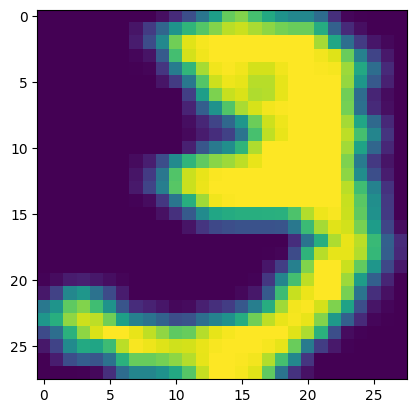

In [8]:
plt.imshow(data2[10][0][0,:,:])
print(len(data1))
data = data1+data2 
print(len(data2))
print(len(data))

In [9]:
train, test = random_split(data, [100000, 20000])
BATCH_SIZE = 256
## Print the length of train and validation datasets
print("Length of Train Datasets: ", len(train))
print("Length of Test Datasets: ", len(test))

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle = True)


Length of Train Datasets:  100000
Length of Test Datasets:  20000


## Convolutional Neural Network (CNN)

We use CNN for model of digit recognition

In [29]:
class CNN(nn.Module):
    
    def linear(self, x):
        return x
    
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_layers = nn.ModuleList([nn.Conv2d(1,32,5), 
                                     nn.Conv2d(32,32,5), 
                                     nn.MaxPool2d(2), 
                                     nn.Dropout(p=0.3), 
                                     nn.Conv2d(32,64,5), 
                                     nn.MaxPool2d(2), 
                                     nn.Dropout(p=0.3),  
                                     
                                     ])
        self.fc_layers = nn.ModuleList([nn.Linear(576,256),
                                        nn.Dropout(p=0.3), 
                                        nn.Linear(256,10),])  
        self.cnn_act = [F.relu,       
                        self.linear,         
                        F.relu,         
                        self.linear,       
                        F.relu,             
                        self.linear,     
                        self.linear,]       
        self.fc_act =  [F.relu,               
                        self.linear,                  
                        F.softmax]
        
        self.n_cnn = len(self.cnn_layers)
        self.n_fc = len(self.fc_layers)
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self,x):
        X = torch.clone(x)
        for i in range(self.n_cnn):
            X = self.cnn_layers[i](X)
            X = self.cnn_act[i](X)
        X = X.view(-1, 576)
        for i in range(self.n_fc):
            X = self.fc_layers[i](X)
            X = self.fc_act[i](X)
        return X

    

def fit(model, data):
    optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
    EPOCHS = 5
    model.train()

    for e in range(EPOCHS):
        correct = 0
        for i, (x_batch,y_batch) in enumerate(data):
            x = Variable(x_batch).float()
            y = Variable(y_batch)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = model.loss(y_pred, y)
            loss.backward()
            optimizer.step()
            predicted = torch.max(y_pred,1)[1] 
            correct += (predicted == y_batch).sum()
            if i % 50 == 0:
                print("{:<15} {:<15} {:<30} {:<30}".format("Epoch: " + str(e), "| Batch: " + str(i), "| Loss: " + str(loss.item()), "| accuracy: " + str(float(correct/float(BATCH_SIZE*(i+1))))))
 

cnn = CNN()

#cnn.forward(image)

## Train Model

In [30]:
fit(cnn,train_loader)

C:\Users\Trung\AppData\Local\Temp\ipykernel_25916\3659422580.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.fc_act[i](X)


Epoch: 0        | Batch: 0      | Loss: 2.302600860595703      | accuracy: 0.109375          
Epoch: 0        | Batch: 50     | Loss: 1.8293664455413818     | accuracy: 0.4466145932674408
Epoch: 0        | Batch: 100    | Loss: 1.6674070358276367     | accuracy: 0.5822246074676514
Epoch: 0        | Batch: 150    | Loss: 1.5579804182052612     | accuracy: 0.6705039143562317
Epoch: 0        | Batch: 200    | Loss: 1.5635383129119873     | accuracy: 0.726387619972229 
Epoch: 0        | Batch: 250    | Loss: 1.5329437255859375     | accuracy: 0.7634928822517395
Epoch: 0        | Batch: 300    | Loss: 1.5124061107635498     | accuracy: 0.7909442186355591
Epoch: 0        | Batch: 350    | Loss: 1.505721926689148      | accuracy: 0.8115540146827698
Epoch: 1        | Batch: 0      | Loss: 1.5424507856369019     | accuracy: 0.91796875        
Epoch: 1        | Batch: 50     | Loss: 1.5132642984390259     | accuracy: 0.9411764740943909
Epoch: 1        | Batch: 100    | Loss: 1.523575782775879   

After training, we save the model

In [14]:
torch.save(cnn.state_dict(), './model/mnist-cnn.pth')

## Evaluate Model

In [31]:
def predict(model,x):
    model.eval()
    y_pred = torch.max(model.forward(x),1)[1]
    return y_pred

In [32]:
def eval(model, test):
    model.eval()
    correct = 0
    for x,y in test:
        y_pred = predict(model,x)
        if(y_pred == y[0]):
            correct += 1
    return correct / len(test)
